In [47]:
%load_ext autoreload
%autoreload 2
import pickle
import glob
import sys, copy
import numpy as np
import pyccl as ccl
import ModelClusterObservables
sys.path.append('../modules/')
import halo._halo_abundance
import halo.halo_catalogue
import matplotlib.pyplot as plt
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)
import itertools
params = {
    "font.family": "serif",
    "font.serif": ["Times", "Times New Roman", "DejaVu Serif"],
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "text.usetex": True,
    "figure.figsize": [3.386, 3.386],
    "figure.dpi": 300,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.05,
    "axes.linewidth": 0.8,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
}
plt.rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import configparser
default_config = configparser.ConfigParser()
default_config.read('../config/capish_internal_validation.ini')
ClusterAbundanceObject = ModelClusterObservables.UniversePrediction( default_config=default_config )

In [49]:
CCLCosmologyObject = ClusterAbundanceObject.params_default['CCL_cosmology']

In [50]:
hmf = halo.halo_catalogue.get_massfunc_from_config(default_config['halo_catalogue'])
bias = halo.halo_catalogue.get_bias_from_config(default_config['halo_catalogue'])
sky_area = float( default_config['halo_catalogue']['sky_area'] )
fsky = sky_area/(4*np.pi) 
logm_grid = np.linspace( float( default_config['halo_catalogue']['log10m_min']),
                        float( default_config['halo_catalogue']['log10m_max']),
                        int( default_config['halo_catalogue']['n_mass_bins'] ) )
z_grid = np.linspace( float( default_config['halo_catalogue']['z_min'] ),
                        float( default_config['halo_catalogue']['z_max'] ),
                        int( default_config['halo_catalogue']['n_redshift_bins'] ) )

In [51]:
HaloAbundance = halo._halo_abundance.HaloAbundance(CCLCosmologyObject = CCLCosmologyObject,
                                                   CCLHmf = hmf, 
                                                   CCLBias = bias,
                                                   sky_area =sky_area)

In [52]:
HaloAbundance.compute_multiplicity_grid_MZ(z_grid = z_grid, log10m_grid = logm_grid)
HaloAbundance.compute_halo_bias_grid_MZ(z_grid = z_grid, log10m_grid = logm_grid)

In [53]:
log10m_edges = np.linspace(13.5, 16, 10)
log10m_center = (log10m_edges[:-1] + log10m_edges[1:]) / 2
z_edges = np.linspace(0.2, 1.2, 5)
def binning(edges): return [[edges[i],edges[i+1]] for i in range(len(edges)-1)]
Redshift_bin = binning(z_edges)
Logm_bin = binning(log10m_edges)
N = HaloAbundance.Cluster_Abundance_MZ(Redshift_bin = Redshift_bin , Proxy_bin = Logm_bin, method = 'simps')
Nb = HaloAbundance.Nhalo_bias_MZ(Redshift_bin = Redshift_bin , Proxy_bin = Logm_bin, method = 'simps')

In [54]:
cosmo_fid = ccl.Cosmology( Omega_c = float( default_config['halo_catalogue']['Omega_c_fiducial'] ), 
                               Omega_b = float( default_config['halo_catalogue']['Omega_b_fiducial'] ), 
                               h = float( default_config['halo_catalogue']['h_fiducial'] ), 
                               sigma8 = float( default_config['halo_catalogue']['sigma_8_fiducial'] ), 
                               n_s=float( default_config['halo_catalogue']['n_s_fiducial'] ) )
Sij = HaloAbundance.compute_theoretical_Sij(Redshift_bin, cosmo_fid, fsky, S_ij_type = 'full_sky_rescaled_approx', )

In [55]:
res_default_capish = load('./capish_sims_at_fiducial_cosmology/count_from_halo_catalogue_default_capish.pkl')
count = [item[0] for item in res_default_capish]

In [56]:
mean_count = np.mean(count, axis=0)
std_count = np.std(count, axis=0)

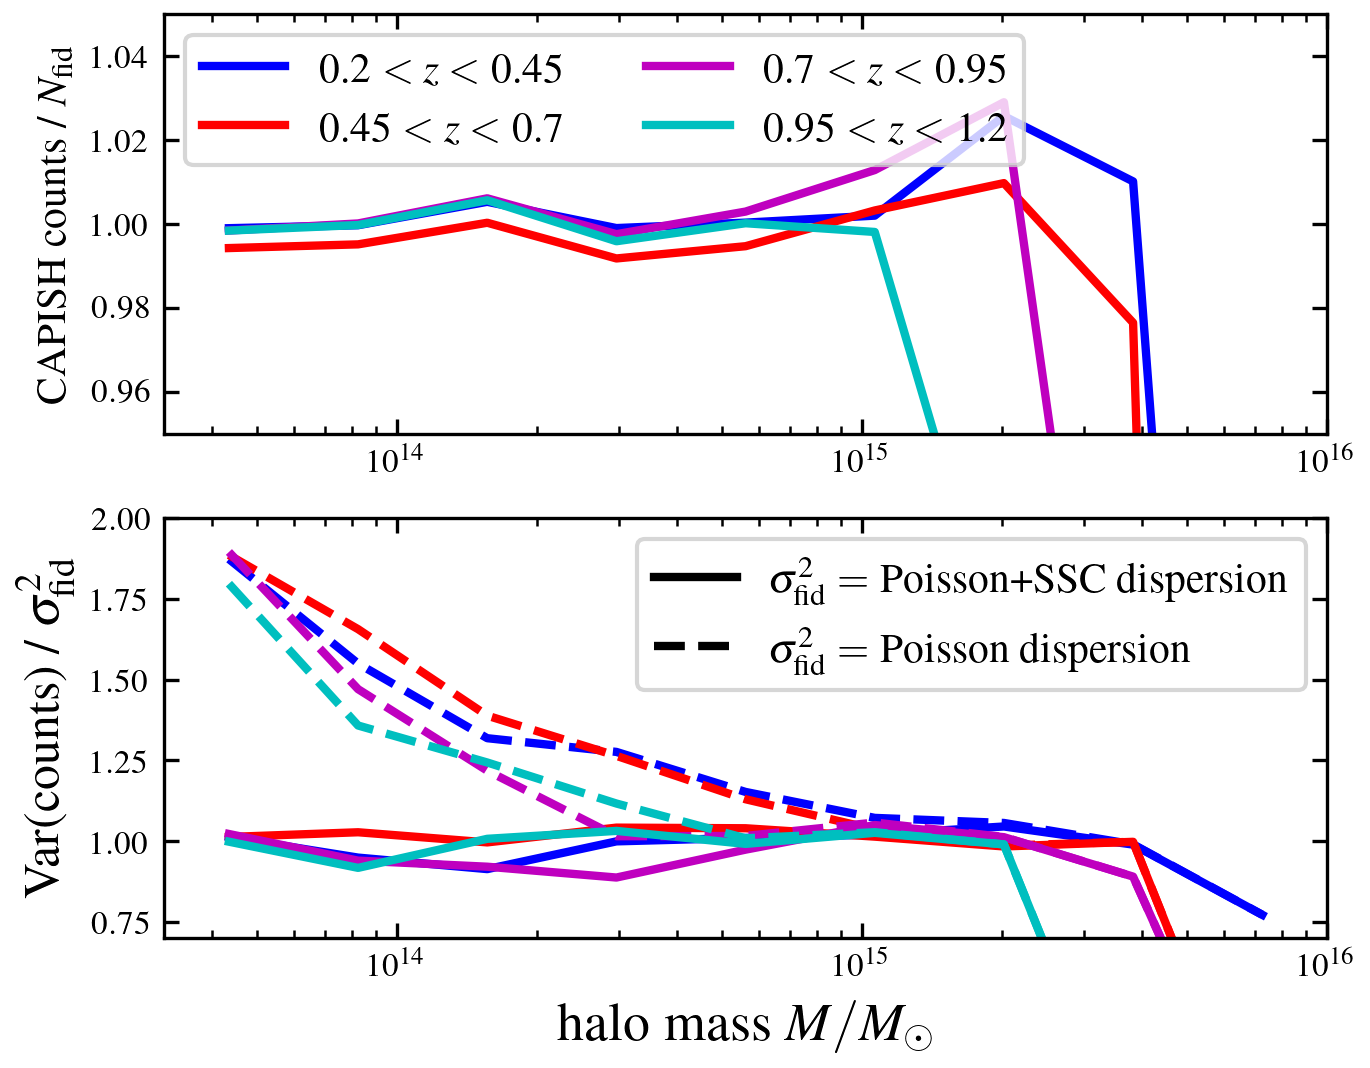

In [57]:
plt.figure(figsize=(5,4))
plt.subplot(211)
color = ["#264653", "#2A9D8F", "#E9C46A", "#F4A261", "#E76F51"]
color = ["b", "r", "m", "c"]
for i in range(len(Redshift_bin)):
    plt.plot(10**log10m_center, mean_count[:,i]/N.T[:,i] , color = color[i], lw=2, label = str(Redshift_bin[i][0]) + r' $< z <$ ' + str(Redshift_bin[i][1]))
plt.ylim(1-0.05, 1+0.05)
plt.ylabel(r'CAPISH counts / $N_{\rm fid}$', fontsize=10)
plt.xscale('log')
plt.legend(ncols=2, loc='upper left', fontsize=10)
plt.xlim(10**13.5, 10**16)
plt.subplot(212)
for i in range(len(Redshift_bin)):
    Sij_in_bin = Sij[i,i]
    varth = N.T[:,i] + Nb.T[:,i]**2 * Sij_in_bin
    plt.plot(10**log10m_center, std_count[:,i]/np.sqrt(varth) , color = color[i], lw=2)
    plt.plot(10**log10m_center, std_count[:,i]/np.sqrt(N.T[:,i]), '--',color = color[i], lw=2)
plt.plot([], [], '-k', lw=2, label = r'$\sigma^2_{\rm fid}=$ Poisson+SSC dispersion')
plt.plot([], [], '--k', lw=2, label = r'$\sigma^2_{\rm fid}=$ Poisson dispersion')
plt.legend(ncols=1, loc='upper right', fontsize=10)
plt.ylabel(r'Var(counts) / $\sigma^2_{\rm fid}$', fontsize=12)
plt.ylim(1-0.3,1+ 1)
plt.xscale('log')
plt.xlim(10**13.5, 10**16)
plt.xlabel(r'halo mass $M/M_\odot$', fontsize=13)
plt.savefig(f'halo_count_bias.png', dpi = 300, bbox_inches='tight',)